In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt



In [ ]:

data= pd.read_csv(r"data\train.csv")

## Data Cleaning

In [ ]:
cleaned_data= data.copy()

In [ ]:
# Age is uniformily distributed
min_val, max_val = cleaned_data['Age'].min(), cleaned_data['Age'].max()
cleaned_data['Age'] = cleaned_data['Age'].fillna(np.random.uniform(min_val, max_val))

# Annual Income dist is right skewed
cleaned_data['Annual Income'] = cleaned_data['Annual Income'].fillna(cleaned_data['Annual Income'].mode()[0])

# Marital Status is uniformly distributed
unique_categories = cleaned_data['Marital Status'].dropna().unique() 
cleaned_data['Marital Status'] = cleaned_data['Marital Status'].fillna(np.random.choice(unique_categories))

# Number of Dependents is uniformaly distributed
min, max = cleaned_data['Number of Dependents'].min(),  cleaned_data['Number of Dependents'].max()
cleaned_data['Number of Dependents']= cleaned_data['Number of Dependents'].fillna(np.random.uniform(min,max))

# Occupation is uniformaly distributed
unique_occupation= cleaned_data['Occupation'].dropna().unique()
cleaned_data['Occupation']= cleaned_data['Occupation'].fillna(np.random.choice(unique_occupation))

# Health Score aprox normally distributed
cleaned_data['Health Score'] = cleaned_data['Health Score'].fillna(cleaned_data['Health Score'].mean())

# Previous Claims
cleaned_data['Previous Claims']= cleaned_data['Previous Claims'].fillna(cleaned_data['Previous Claims'].mode()[0])

# Vehicle age in uniformally dist
min_age, max_age= cleaned_data['Vehicle Age'].min(), cleaned_data['Vehicle Age'].max()
cleaned_data['Vehicle Age']=cleaned_data['Vehicle Age'].fillna(np.random.uniform(min_age, max_age)) 

# Credit Score is aprox uniformally dist
min_score, max_score= cleaned_data['Credit Score'].min(), cleaned_data['Credit Score'].max()
cleaned_data['Credit Score']= cleaned_data['Credit Score'].fillna(np.random.uniform(min_score, max_score))

# Insurance duration
min_dur, max_dur= cleaned_data['Insurance Duration'].min(), cleaned_data['Insurance Duration'].max()
cleaned_data['Insurance Duration']=cleaned_data['Insurance Duration'].fillna(np.random.uniform(min_dur, max_dur))

# Customer Feedback 
unique_feedback= cleaned_data['Customer Feedback'].dropna().unique()
cleaned_data['Customer Feedback']=cleaned_data['Customer Feedback'].fillna(np.random.choice(unique_feedback))




In [ ]:
# change to date format
cleaned_data['Policy Start Date'] = pd.to_datetime(cleaned_data['Policy Start Date'])



In [ ]:
cleaned_data.drop(columns='id', inplace=True)

In [ ]:
cleaned_data.dtypes

Age                            float64
Gender                          object
Annual Income                  float64
Marital Status                  object
Number of Dependents           float64
Education Level                 object
Occupation                      object
Health Score                   float64
Location                        object
Policy Type                     object
Previous Claims                float64
Vehicle Age                    float64
Credit Score                   float64
Insurance Duration             float64
Policy Start Date       datetime64[ns]
Customer Feedback               object
Smoking Status                  object
Exercise Frequency              object
Property Type                   object
Premium Amount                 float64
dtype: object

## Feature Engineering

In [ ]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [ ]:
max_date= cleaned_data['Policy Start Date'].max()

cleaned_data['Years Insured'] = (max_date - cleaned_data['Policy Start Date']).dt.days / 365.25


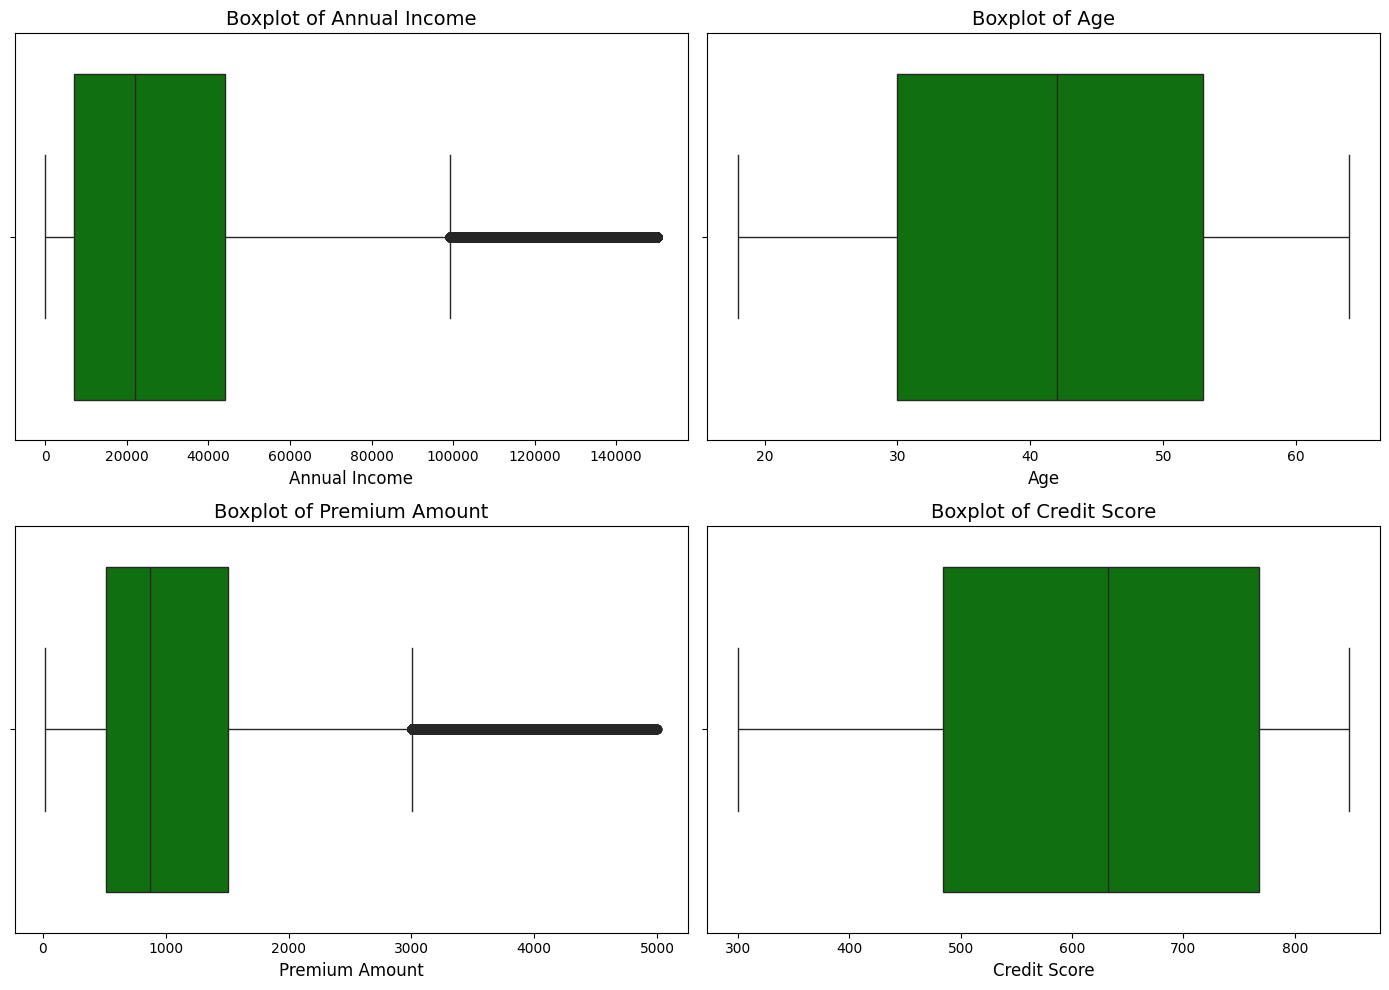

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
columns = ['Annual Income', 'Age', 'Premium Amount', 'Credit Score']

# Plot each feature in a subplot
for ax, column in zip(axes.flatten(), columns):
    sns.boxplot(x=cleaned_data[column], ax=ax, color='green')
    ax.set_title(f"Boxplot of {column}", fontsize=14)
    ax.set_xlabel(column, fontsize=12)

# Adjust layout and display
plt.tight_layout()
plt.show()

In [ ]:
# Handle Outliers
# Calculate the IQR for "Premium Amount"
prem_Q1 = cleaned_data['Premium Amount'].quantile(0.25)
prem_Q3 = cleaned_data['Premium Amount'].quantile(0.75)
prem_IQR = prem_Q3 - prem_Q1

# Define the bounds for outliers for "Premium Amount"
prem_lower_bound = prem_Q1 - 1.5 * prem_IQR
prem_upper_bound = prem_Q3 + 1.5 * prem_IQR

# Identify the outliers for "Premium Amount"
prem_outliers = cleaned_data[(cleaned_data['Premium Amount'] < prem_lower_bound) | 
                             (cleaned_data['Premium Amount'] > prem_upper_bound)]

# Now do the same for "Income" or any other feature you are analyzing
income_Q1 = cleaned_data['Annual Income'].quantile(0.25)
income_Q3 = cleaned_data['Annual Income'].quantile(0.75)
income_IQR = income_Q3 - income_Q1

# Define the bounds for outliers for "Income"
income_lower_bound = income_Q1 - 1.5 * income_IQR
income_upper_bound = income_Q3 + 1.5 * income_IQR

# Identify the outliers for "Income"
income_outliers = cleaned_data[(cleaned_data['Annual Income'] < income_lower_bound) | 
                               (cleaned_data['Annual Income'] > income_upper_bound)]


In [ ]:
# For "Premium Amount"
data_outliers_removed = cleaned_data[
    (cleaned_data['Premium Amount'] >= prem_lower_bound) & 
    (cleaned_data['Premium Amount'] <= prem_upper_bound) &
    (cleaned_data['Annual Income'] >= income_lower_bound) & 
    (cleaned_data['Annual Income'] <= income_upper_bound)]

In [ ]:
len(data_outliers_removed)/len(data)

0.906395

##### About 10% of data removed during cleaning

In [ ]:


data_encoded = cleaned_data.copy()

# List of columns to apply label encoding
label_columns = ['Gender', 'Marital Status', 'Occupation', 'Location',
                 'Property Type', 'Education Level', 'Customer Feedback', 
                 'Smoking Status', 'Exercise Frequency', 'Policy Type']

# Initialize LabelEncoder
encoder = LabelEncoder()

# Apply Label Encoding to each column in label_columns directly on the DataFrame
for col in label_columns:
    data_encoded[col] = encoder.fit_transform(data_encoded[col])
# 3. Scaling numerical columns
numerical_columns = ['Age', 'Annual Income', 'Number of Dependents', 'Health Score', 
                     'Vehicle Age', 'Credit Score', 'Insurance Duration']

# Initialize the StandardScaler
scaler = StandardScaler()

# Apply scaling to the numerical columns
data_encoded[numerical_columns] = scaler.fit_transform(data_encoded[numerical_columns])



## Regression model

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

In [ ]:
sampled_df = data_encoded.sample(n=50000, random_state=42)

# Step 3: Prepare the data
X = sampled_df['Age','Gender','Annual Income','Credit Score',
        'Insurance Duration',
        'Health Score',
        'Policy Type']  

# Features
y = sampled_df['Premium Amount']  # Target variable

# Step 4: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 5: Initialize the Gradient Boosting Regressor model
gb_regressor = GradientBoostingRegressor(n_estimators=100, random_state=42)

# Step 6: Fit the model on the training data
gb_regressor.fit(X_train, y_train)

# Step 7: Make predictions on the test set
y_pred = gb_regressor.predict(X_test)

# Step 8: Evaluate the model using Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')